In [32]:
import gym
from gym import spaces
import numpy as np

class TicTacToeEnv(gym.Env):
    def __init__(self):
        super(TicTacToeEnv, self).__init__()
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Discrete(3**9)
        self.reset()

    def reset(self):
        self.state = np.zeros(9, dtype=int)
        self.done = False
        self.current_player = 1
        return self._get_obs()

    def step(self, action):
        if self.done or self.state[action] != 0:
            return self._get_obs(), -10, True, {}
        self.state[action] = self.current_player
        if self._check_win(self.current_player):
            self.done = True
            return self._get_obs(), 10, True, {}
        if np.all(self.state != 0):
            self.done = True
            return self._get_obs(), 0, True, {}
        self.current_player = 3 - self.current_player
        return self._get_obs(), 0, False, {}

    def _get_obs(self):
        return int("".join(str(s) for s in self.state), 3)

    def _check_win(self, player):
        for i in range(3):
            if np.all(self.state[i*3:(i+1)*3] == player) or np.all(self.state[[i, i+3, i+6]] == player):
                return True
        if self.state[0] == self.state[4] == self.state[8] == player or self.state[2] == self.state[4] == self.state[6] == player:
            return True
        return False

    def render(self, mode='human'):
        symbols = {0: ' ', 1: 'X', 2: 'O'}
        board = [symbols[s] for s in self.state]
        for i in range(0, 9, 3):
            print('|'.join(board[i:i+3]))
            if i < 6:
                print("-----")



In [33]:
import numpy as np
import random

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_rate=0.95, exploration_rate=1.0, exploration_decay=0.99, min_exploration_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.choice(range(self.action_size))
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state, done):
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        
        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (reward + self.discount_rate * next_max)
        self.q_table[state, action] = new_value
        
        if done:
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)



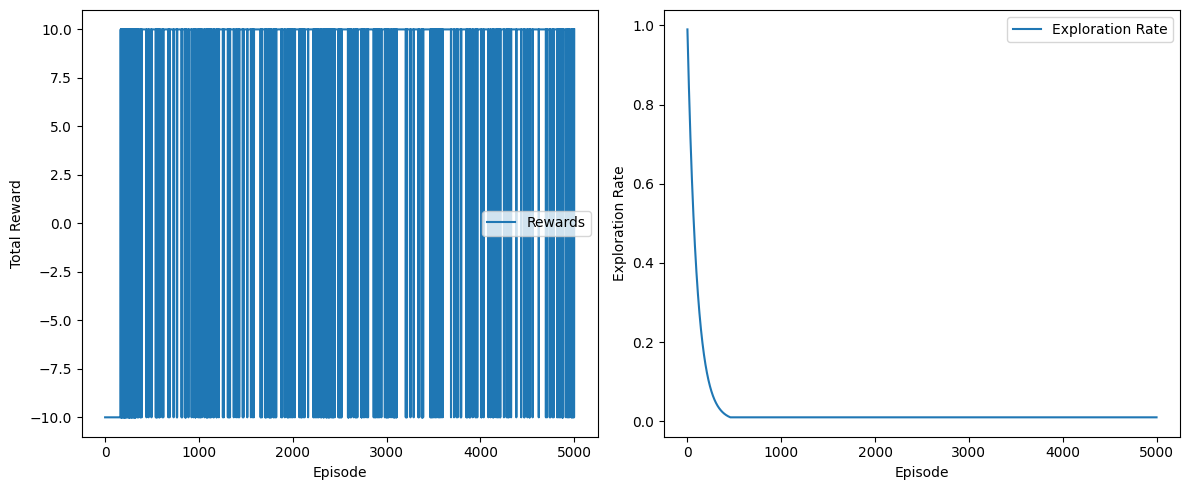

Training completed.


In [34]:

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Assuming TicTacToeEnv and QLearningAgent are already defined and imported
env = TicTacToeEnv()
agent = QLearningAgent(state_size=3**9, action_size=9)

def plot_metrics(metrics):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(metrics['episodes'], metrics['rewards'], label='Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['episodes'], metrics['exploration_rate'], label='Exploration Rate')
    plt.xlabel('Episode')
    plt.ylabel('Exploration Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Training loop
episodes = 5000
metrics = {'episodes': [], 'rewards': [], 'exploration_rate': []}

for episode in range(1, episodes + 1):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
    # Logging
    metrics['episodes'].append(episode)
    metrics['rewards'].append(total_reward)
    metrics['exploration_rate'].append(agent.exploration_rate)
    
    # Plotting
    if episode % 100 == 0:
        clear_output(wait=True)
        plot_metrics(metrics)

print("Training completed.")

In [35]:
def human_vs_agent_play(agent, env):
    state = env.reset()
    done = False
    is_human_turn = True if input("Do you want to go first? (y/n): ").strip().lower() == 'y' else False

    while not done:
        env.render(mode='human')
        
        if is_human_turn:
            # Human's turn
            action = -1
            while action not in range(9) or env.state[action] != 0:
                try:
                    action = int(input("Your move (0-8): "))
                    if env.state[action] != 0:
                        print("Invalid move, cell already taken. Please try again.")
                except ValueError:
                    print("Invalid input. Please enter a number between 0 and 8.")
            
            _, reward, done, _ = env.step(action)
        else:
            # Agent's turn
            legal_actions = [i for i in range(9) if env.state[i] == 0]
            if legal_actions:
                state_int = env._get_obs()  # Get current state as integer for Q-table
                q_values = agent.q_table[state_int]
                q_values_filtered = np.full(env.action_space.n, -np.inf)  # -inf for illegal actions
                q_values_filtered[legal_actions] = q_values[legal_actions]  # Only legal actions considered
                action = np.argmax(q_values_filtered)
                _, reward, done, _ = env.step(action)
                print(f"Agent's move: {action}")
        
        if done:
            env.render(mode='human')
            if reward == 10:
                print("Game Over. " + ("You win!" if is_human_turn else "You lose!"))
            elif reward == -10:
                print("Game Over. " + ("You lose!" if is_human_turn else "You win!"))
            else:
                print("Game Over. It's a draw.")
            break
            
        is_human_turn = not is_human_turn

In [36]:
human_vs_agent_play(agent, env)


 | | 
-----
 | | 
-----
 | | 
 | | 
-----
 |X| 
-----
 | | 
Agent's move: 0
O| | 
-----
 |X| 
-----
 | | 
O| | 
-----
 |X| 
-----
X| | 
Agent's move: 1
O|O| 
-----
 |X| 
-----
X| | 
O|O|X
-----
 |X| 
-----
X| | 
Game Over. You win!


In [37]:
print(state)

12294
